# This is  draft version 1 of the notebook used for the data storm 2.0

In [3]:
!pip install catboost

     |████████████████████████████████| 65.7MB 68kB/s 


Import the required modules 



In [4]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from datetime import datetime,timedelta

Read csv to pandas dataframe

In [5]:
drive.mount('/content/gdrive')
train= pd.read_csv('/content/gdrive/MyDrive/Data storm 2.0/Data/Hotel-A-train.csv')
validation = pd.read_csv('/content/gdrive/MyDrive/Data storm 2.0/Data/Hotel-A-validation.csv')
test= pd.read_csv('/content/gdrive/MyDrive/Data storm 2.0/Data/Hotel-A-test.csv')

Mounted at /content/gdrive


In [ ]:
train.shape

(27499, 24)

In [ ]:
train.head()

,Reservation-id,Gender,Age,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Expected_checkin,Expected_checkout,Booking_date,Adults,Children,Babies,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Reservation_Status,Use_Promotion,Discount_Rate,Room_Rate
0,39428300,F,40,Latino,Grad,<25K,North,City Hotel,7/1/2015,7/2/2015,5/21/2015,2,2,0,BB,No,No,No Deposit,Online,Yes,Check-In,Yes,10,218
1,77491756,F,49,Latino,Mid-School,50K -- 100K,East,City Hotel,7/1/2015,7/2/2015,5/26/2015,3,3,0,BB,No,No,Refundable,Online,Yes,Check-In,No,0,185
2,73747291,F,42,caucasian,Grad,<25K,East,City Hotel,7/2/2015,7/6/2015,6/29/2015,3,3,0,BB,No,No,No Deposit,Online,Yes,Check-In,No,0,119
3,67301739,M,25,African American,College,>100K,South,Airport Hotels,7/2/2015,7/3/2015,6/20/2015,4,3,0,BB,No,No,Refundable,Agent,Yes,Check-In,Yes,5,144
4,77222321,F,62,Latino,High-School,25K --50K,East,Resort,7/3/2015,7/4/2015,6/20/2015,1,1,0,BB,No,No,No Deposit,Direct,No,Check-In,Yes,10,242


In [ ]:
train.isnull().sum()

Reservation-id            0
Gender                    0
Age                       0
Ethnicity                 0
Educational_Level         0
Income                    0
Country_region            0
Hotel_Type                0
Expected_checkin          0
Expected_checkout         0
Booking_date              0
Adults                    0
Children                  0
Babies                    0
Meal_Type                 0
Visted_Previously         0
Previous_Cancellations    0
Deposit_type              0
Booking_channel           0
Required_Car_Parking      0
Reservation_Status        0
Use_Promotion             0
Discount_Rate             0
Room_Rate                 0
dtype: int64

In [ ]:
train.dtypes

Reservation-id             int64
Gender                    object
Age                        int64
Ethnicity                 object
Educational_Level         object
Income                    object
Country_region            object
Hotel_Type                object
Expected_checkin          object
Expected_checkout         object
Booking_date              object
Adults                     int64
Children                   int64
Babies                     int64
Meal_Type                 object
Visted_Previously         object
Previous_Cancellations    object
Deposit_type              object
Booking_channel           object
Required_Car_Parking      object
Reservation_Status        object
Use_Promotion             object
Discount_Rate              int64
Room_Rate                  int64
dtype: object

In [ ]:
train['Reservation_Status'].value_counts()

# Functions

In [6]:
def get_month(date):
  return int(date.split('/')[0])

In [7]:
def get_day(date):
  return int(date.split('/')[1])

In [8]:
def get_year(date):
  return int(date.split('/')[2])

In [9]:
def get_week_of_year(date):
  return datetime.strptime(date, "%m/%d/%Y").isocalendar()[1]

In [10]:
def get_days(start,end):
  return (datetime.strptime(end, "%m/%d/%Y").date() -datetime.strptime(start, "%m/%d/%Y").date()).days

In [11]:
def get_day_of_year(date_string):
  return (datetime.strptime(date_string, '%m/%d/%Y')).timetuple().tm_yday

In [12]:
# returns [Friday, Saturday, etc.]
def get_day_of_week(date_string):
  return datetime.strptime(date_string, '%m/%d/%Y').strftime('%A')

In [13]:
def workdays(start, end, excluded=(6, 7)):
  start= datetime.strptime(start, "%m/%d/%Y")
  end= datetime.strptime(end, "%m/%d/%Y")
  days = []
  while start.date() <= end.date():
      if start.isoweekday() not in excluded:
          days.append(start)
      start += timedelta(days=1)
  return len(days)

In [14]:
def weekend_days(start, end, included=(6, 7)):
  start= datetime.strptime(start, "%m/%d/%Y")
  end= datetime.strptime(end, "%m/%d/%Y")
  days = []
  while start.date() <= end.date():
      if start.isoweekday()  in included:
          days.append(start)
      start += timedelta(days=1)
  return len(days)

Feature enginering  


In [15]:
def feature_eng(df):
  adr_mapping=df.groupby([df["Expected_checkin"], "Hotel_Type"])["Room_Rate"].mean()
  df['Expected_duration']=df.apply(lambda x:get_days(x['Expected_checkin'],x['Expected_checkout']),axis=1)
  df['Expected_weekdays']=df.apply(lambda x:workdays(x['Expected_checkin'],x['Expected_checkout']),axis=1)
  df['Expected_weekends']=df.apply(lambda x:weekend_days(x['Expected_checkin'],x['Expected_checkout']),axis=1)
  df['No_of_date_between_booking_date_expected_checkin']=df.apply(lambda x:get_days(x['Booking_date'],x['Expected_checkin']),axis=1)
  df['No_of_date_between_booking_date_expected_checkout']=df.apply(lambda x:get_days(x['Booking_date'],x['Expected_checkout']),axis=1)
  df['Expected_checkin_month']=df.apply(lambda x:get_month(x['Expected_checkin']),axis=1)
  df['Expected_checkout_month']=df.apply(lambda x:get_month(x['Expected_checkout']),axis=1)
  df['Booking_date_month']=df.apply(lambda x:get_month(x['Booking_date']),axis=1)
  df['Expected_checkin_year']=df.apply(lambda x:get_year(x['Expected_checkin']),axis=1)
  df['Expected_checkout_year']=df.apply(lambda x:get_year(x['Expected_checkout']),axis=1)
  df['Booking_date_year']=df.apply(lambda x:get_year(x['Booking_date']),axis=1)
  df['Expected_checkin_date']=df.apply(lambda x:get_day(x['Expected_checkin']),axis=1)
  df['Expected_checkout_date']=df.apply(lambda x:get_day(x['Expected_checkout']),axis=1)
  df['Booking_date_date']=df.apply(lambda x:get_day(x['Booking_date']),axis=1)
  df['Expected_checkin_week']=df.apply(lambda x:get_week_of_year(x['Expected_checkin']),axis=1)
  df['Expected_checkout_week']=df.apply(lambda x:get_week_of_year(x['Expected_checkout']),axis=1)
  df['Booking_date_week']=df.apply(lambda x:get_week_of_year(x['Booking_date']),axis=1)
  df=df.drop(['Expected_checkin', 'Expected_checkout','Booking_date'], axis = 1) 
  return df

change columns data types

In [16]:
gender_mapping = {"F":1, "M":2}
education_level_mapping = {"Mid-School":1, "High-School":2,"College":3,"Grad":4}
income_mapping={"<25K":1,"25K --50K":2,"50K -- 100K":3,">100K":4}
meal_mapping={"BB":1,"HB":2,"FB":3}
deposite_mapping={"No Deposit":1,"Refundable":2,"Non-Refundable":3}
reservation_mapping={"Check-In":1,"Canceled":2,"No-Show":3}
boolean_mapping={"Yes":1,"No":0}
def mapping(df,test=False):
  df["Gender_Enc"] = df["Gender"].replace(gender_mapping)
  df["Educational_Level_Enc"] = df["Educational_Level"].replace(education_level_mapping)
  df["Income_Enc"] = df["Income"].replace(income_mapping)
  df["Meal_Type_Enc"] = df["Meal_Type"].replace(meal_mapping)
  df["Deposit_type_EnC"] = df["Deposit_type"].replace(deposite_mapping)
  if(~test):
    df["Reservation_Status_Enc"] = df["Reservation_Status"].replace(reservation_mapping)
  df["Visted_Previously_Enc"] = df["Visted_Previously"].replace(boolean_mapping)
  df["Required_Car_Parking_Enc"] = df["Required_Car_Parking"].replace(boolean_mapping)
  df["Previous_Cancellations_Enc"] = df["Previous_Cancellations"].replace(boolean_mapping)
  df["Use_Promotion_Enc"] = df["Use_Promotion"].replace(boolean_mapping)
  col=['Gender', 'Educational_Level','Income','Meal_Type','Deposit_type','Reservation_Status','Visted_Previously','Required_Car_Parking','Previous_Cancellations','Use_Promotion','Reservation-id']
  if(test):
    col.remove('Reservation_Status')
  df=df.drop(col, axis = 1) 
  return df


use oneHotEncoder

In [17]:
def oneHotEncoder(df):
  return pd.get_dummies(data=df, columns=['Ethnicity','Country_region', 'Hotel_Type','Booking_channel'])

Preprocessor

In [18]:
def preprocessor(df,test=False):
  df=feature_eng(df)
  df= mapping(df)
  df=oneHotEncoder(df)
  cols_to_norm=df.columns.to_list()
  if(test):
    scaler= MinMaxScaler()
    df[cols_to_norm]= scaler.fit_transform(df[cols_to_norm])
    return df
  cols_to_norm.remove('Reservation_Status_Enc')
  scaler= MinMaxScaler()
  df[cols_to_norm]= scaler.fit_transform(df[cols_to_norm])
  X= df.drop('Reservation_Status_Enc',axis=1)
  y=df['Reservation_Status_Enc']
  return (X,y,df)

Visulaization

In [19]:
train_X, train_y,train_df= preprocessor(train)

In [ ]:
train_df.skew()

Age                                                  0.003686
Adults                                               0.860928
Children                                             0.428316
Babies                                               1.399147
Discount_Rate                                        0.716332
Room_Rate                                           -0.000533
Expected_duration                                    0.855781
No_of_date_between_booking_date_expected_checkin     0.799717
No_of_date_between_booking_date_expected_checkout    0.800566
Expected_checkin_month                               0.051554
Expected_checkout_month                              0.044349
Booking_date_month                                  -0.125381
Gender_Enc                                           0.007201
Educational_Level_Enc                               -0.271930
Income_Enc                                           0.180126
Meal_Type_Enc                                        0.640583
Deposit_

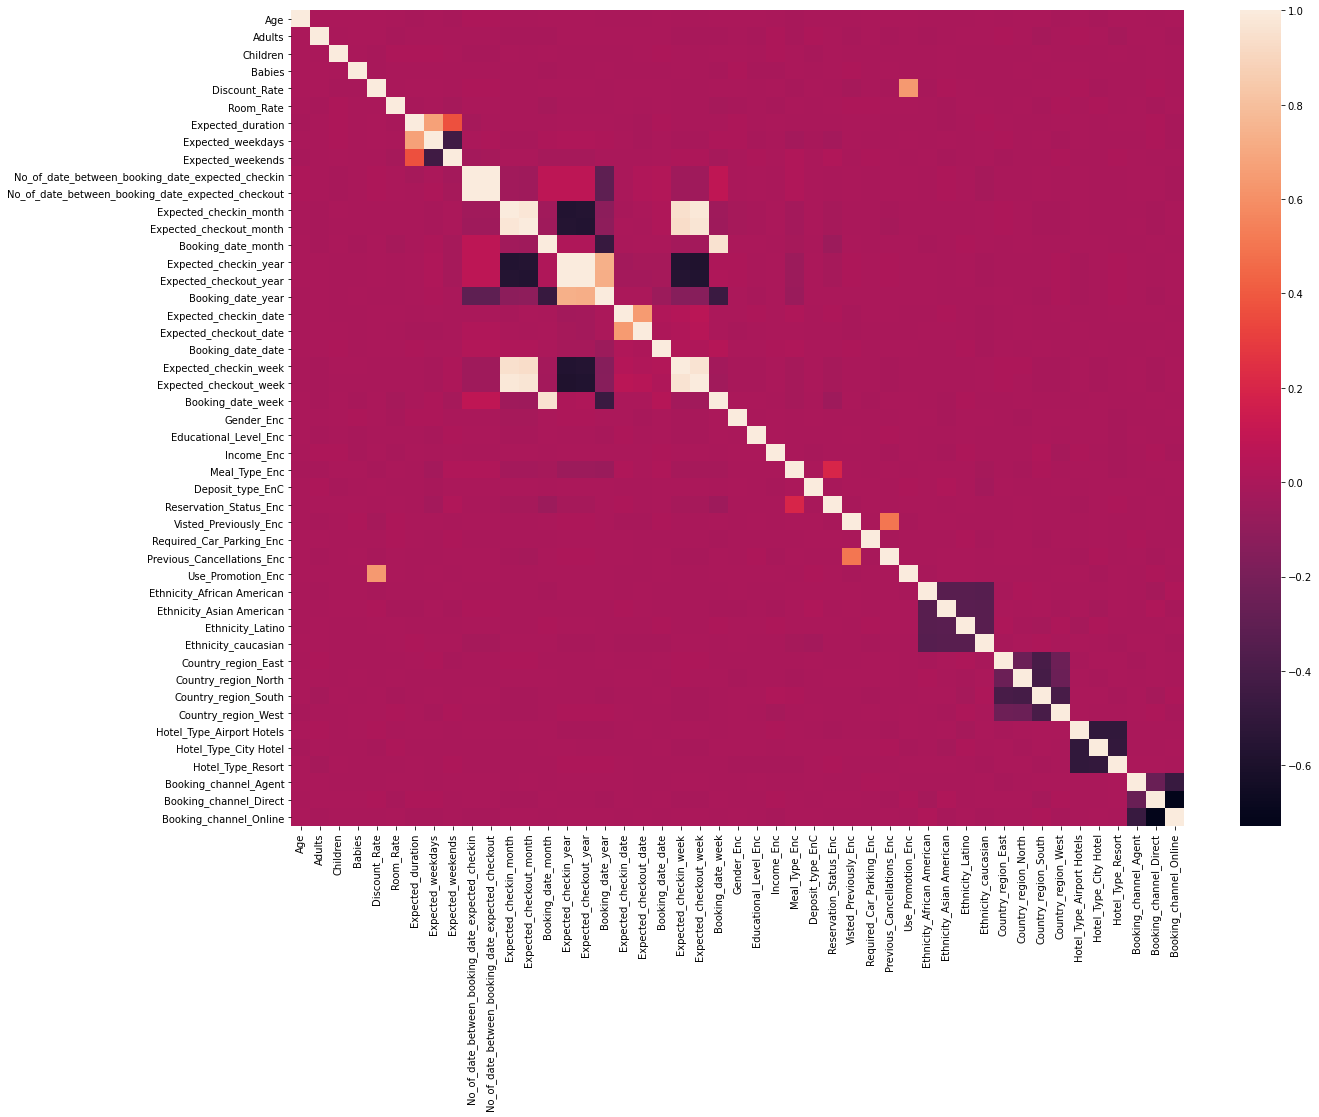

In [20]:
import seaborn as sns 
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,15))
ax = sns.heatmap(train_df.corr())

Model evaluation

In [21]:
train_X, train_y,train_df= preprocessor(train)
validattion_X,validation_y,validation_df= preprocessor(validation)
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=400)),
               ("XT_model",ExtraTreesClassifier()),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1,max_iter=250)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1)),
               ("MLP_model",MLPClassifier(random_state=42)),
               ("Knn_model",KNeighborsClassifier(n_neighbors=3)),
               ("LightGBM",LGBMClassifier()),
               ("CatBoost",CatBoostClassifier(n_estimators=400)),
               ("NB_model",GaussianNB()),
               ("LDA_model",LinearDiscriminantAnalysis())]

for name, model in (base_models):
  scores = cross_val_score(model, train_X, train_y, scoring='f1_macro', cv=cv, n_jobs=-1)
  print(f"{name} F1 Score: {round(np.mean(scores),4), round(np.std(scores),4)}")

DT_model F1 Score: (0.3717, 0.0077)


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RF_model F1 Score: (0.2907, 0.0003)
XT_model F1 Score: (0.2914, 0.0008)
LR_model F1 Score: (0.2905, 0.0)
XGB_model F1 Score: (0.2905, 0.0)
MLP_model F1 Score: (0.3267, 0.0112)
Knn_model F1 Score: (0.3262, 0.002)
LightGBM F1 Score: (0.2913, 0.0005)
CatBoost F1 Score: (0.3087, 0.0039)
NB_model F1 Score: (0.321, 0.0045)
LDA_model F1 Score: (0.2905, 0.0)


In [22]:
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix,confusion_matrix,homogeneity_completeness_v_measure,accuracy_score,adjusted_rand_score
train_X, train_y,train_df= preprocessor(train)
validattion_X,validation_y,validation_df= preprocessor(validation)
model=DecisionTreeClassifier()
model.fit(train_X,train_y)
pred=model.predict(validattion_X)
acc= accuracy_score(validation_y,pred)
fscore=f1_score(validation_y,pred,average="macro")
print(acc,fscore)

0.5332848308475809 0.3278970057009579


In [ ]:
test_X,test_y,test_df= preprocessor(test,test=True)
test_pred=model.predict(test_X,test=True)
reservation_outcome_mapping={1:"Check-In",2:"Canceled",3:"No-Show"}
test_pred["Reservation_Status"] = test_pred["Reservation_Status"].replace(reservation_outcome_mapping)



KeyError: ignored

In [32]:
adr_mapping=pd.DataFrame({'ADR' :train.groupby([train["Expected_checkin"], "Hotel_Type"])["Room_Rate"].mean()}).reset_index()
adr_mapping[adr_mapping['Expected_checkin']=='1/1/2016'].head()
# adr_mapping.head(20)

,Expected_checkin,Hotel_Type,ADR
1,1/1/2016,Airport Hotels,203.500000
2,1/1/2016,City Hotel,199.166667
3,1/1/2016,Resort,175.000000


In [ ]:
train_X.head()

,Age,Adults,Children,Babies,Discount_Rate,Room_Rate,Expected_duration,No_of_date_between_booking_date_expected_checkin,No_of_date_between_booking_date_expected_checkout,Expected_checkin_month,Expected_checkout_month,Booking_date_month,Expected_weekdays,Expected_weekends,Gender_Enc,Educational_Level_Enc,Income_Enc,Meal_Type_Enc,Deposit_type_EnC,Visted_Previously_Enc,Required_Car_Parking_Enc,Previous_Cancellations_Enc,Use_Promotion_Enc,Ethnicity_African American,Ethnicity_Asian American,Ethnicity_Latino,Ethnicity_caucasian,Country_region_East,Country_region_North,Country_region_South,Country_region_West,Hotel_Type_Airport Hotels,Hotel_Type_City Hotel,Hotel_Type_Resort,Booking_channel_Agent,Booking_channel_Direct,Booking_channel_Online
0,0.423077,0.25,0.5,0.0,0.250,0.786667,0.0,0.063202,0.059238,0.545455,0.545455,0.363636,0.4,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.596154,0.50,1.0,0.0,0.000,0.566667,0.0,0.056180,0.052186,0.545455,0.545455,0.363636,0.4,0.0,0.0,0.000000,0.666667,0.0,0.5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.461538,0.50,1.0,0.0,0.000,0.126667,1.0,0.009831,0.009873,0.545455,0.545455,0.454545,0.6,1.0,0.0,1.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.134615,0.75,1.0,0.0,0.125,0.293333,0.0,0.022472,0.018336,0.545455,0.545455,0.454545,0.4,0.0,1.0,0.666667,1.000000,0.0,0.5,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.846154,0.00,0.0,0.0,0.250,0.946667,0.0,0.023876,0.019746,0.545455,0.545455,0.454545,0.2,0.5,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Feature: 0, Score: 0.10924
Feature: 1, Score: 0.03705
Feature: 2, Score: 0.02322
Feature: 3, Score: 0.01917
Feature: 4, Score: 0.04771
Feature: 5, Score: 0.11776
Feature: 6, Score: 0.02592
Feature: 7, Score: 0.07569
Feature: 8, Score: 0.09689
Feature: 9, Score: 0.02656
Feature: 10, Score: 0.02970
Feature: 11, Score: 0.03536
Feature: 12, Score: 0.01506
Feature: 13, Score: 0.03353
Feature: 14, Score: 0.03567
Feature: 15, Score: 0.03179
Feature: 16, Score: 0.02424
Feature: 17, Score: 0.01588
Feature: 18, Score: 0.01670
Feature: 19, Score: 0.00971
Feature: 20, Score: 0.00789
Feature: 21, Score: 0.01193
Feature: 22, Score: 0.01015
Feature: 23, Score: 0.01265
Feature: 24, Score: 0.01229
Feature: 25, Score: 0.01307
Feature: 26, Score: 0.01051
Feature: 27, Score: 0.01391
Feature: 28, Score: 0.01138
Feature: 29, Score: 0.01120
Feature: 30, Score: 0.01322
Feature: 31, Score: 0.01097
Feature: 32, Score: 0.01175
Feature: 33, Score: 0.01112
Feature: 34, Score: 0.01111


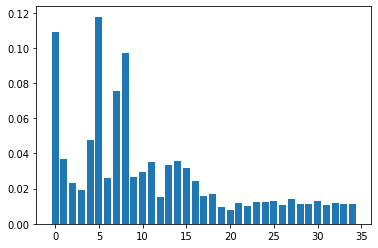

In [ ]:
from matplotlib import pyplot
model = DecisionTreeClassifier()
# fit the model
model.fit(train_X, train_y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()